In [1]:
import lxml.html
import requests
import re
import os
import time
import datetime
import pandas as pd
from pprint import pprint
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

In [2]:
print("Pandas:",pd.__version__)

Pandas: 1.2.3


## Functions

In [3]:
def get_details(urls):
    """
    input:
        - urls: generator object, 詳細ページのurlを生成するgenerator
    output: usedcars DF
    """
    carsDF = None
    for url in urls:
        key = extract_key(url)    
        usedcar = scrape_detail_page(url, key)
        try:
            df_ = pd.DataFrame(usedcar,index=[0])
        except Exception as e:
            print(e)
            print("Error converting dict to DF")
            pprint(usedcar)
            return None
        if carsDF is None:
            carsDF = df_
        else:
            carsDF = pd.concat([carsDF,df_],ignore_index=True)
    return carsDF
        


def get_lastpage_num(url):
    """
    リストページのhtmlからリストページの総数を取得して返す
    intput:
        - url: str
    output:
        - last_num: int, リストページ数
    """
    response = requests.get(url)
    root = lxml.html.fromstring(response.content)
    # 最後のlistページのurlを取得する
    last_page = root.cssselect(CSS_LAST_PAGE_NUM)[0]
    # urlから最後のindex番号を取得する
    last_index = last_page.get('href').split("/")[-1]
    m = re.search('index([0-9]+)', last_index)
    # re.search()でマッチしなかった場合のエラー処理
    if m is None:
        raise ValueError('index.html of last page is not found')
    last_num = int(m.group(1))
    return last_num


def scrape_list_page(url):
    """
    リストページから詳細ページのurlを取得し、生成する(generator object)
    input:
        - url: str, リストページのurl
    output:
        generator object, 詳細ページのurlを生成する
    """
    # webページ読み込み、response.contentから文字列を取得してパース
    response = requests.get(url)
    root = lxml.html.fromstring(response.content)
    # 全てのurlを絶対urlに変換
    root.make_links_absolute(response.url)
    htmlElems = root.cssselect(CSS_DETAIL_PAGE_URL)
    for elem in htmlElems:
        url = elem.get('href')
        yield url


def scrape_detail_page(url, key):
    """
    詳細ページから各種情報を取得し、dictで返す
    input:
        - url: str, 詳細ページのurl
        - key: str, 詳細ページのurlに対するキー
    output:
        - usedcar: dict, dbに格納するドキュメント
    """
    true_mark = "◯"

    response = requests.get(url)
    root = lxml.html.fromstring(response.content)

    # 本体価格---------------------------------------------------------------
    base_price = root.cssselect(CSS_BODY_PRICE)
    base_price = base_price[0].get('content').replace(',', '')
    base_price = int(base_price)
    # 本体価格応相談の場合はNullにする
    if base_price > 90000000:
        base_price = None
    # 支払総額---------------------------------------------------------------
    total_price = root.cssselect(CSS_TOTAL_PRICE)
    total_price = total_price[0].text_content()
    total_price = re.sub(r'\n(\t)+', '', total_price).replace('万円', '')
    try:
        total_price = int(float(total_price) * 10000)
    except ValueError:
        total_price = None
    # 年式---------------------------------------------------------------
    model_year = root.cssselect(CSS_MODEL_YEAR)
    model_year = model_year[0].text
    model_year = int(model_year)
    # 走行距離---------------------------------------------------------------
    distance = root.cssselect(CSS_DISTANCE)
    distance = distance[0].text_content()
    distance = re.sub(r'\n(\t)+', '', distance).strip().replace('走行距離', '')
    if '万' in distance:
        distance = distance.replace('万km', '')
        try:
            distance = float(distance)
        except ValueError:
            distance = None
    else:
        distance = distance.replace('km', '')
        try:
            distance = float(distance) / 10000
        except ValueError:
            distance = None
    # 車検---------------------------------------------------------------
    inspection = root.cssselect(CSS_INSPECTION)
    inspection = inspection[0].text_content()
    inspection = re.sub(r'\n(\t)+', '', inspection).replace('車検有無', '')
    # 修復歴---------------------------------------------------------------
    repare = root.cssselect(CSS_REPARE)
    repare = repare[0].text
    # 本体情報等---------------------------------------------------------------
    info = root.cssselect(CSS_CAR_INFO)
    info = info[0].text
    info = info.replace(EM_SPACE, ' ').replace(NBSP, ' ')
    # 駆動方式----------------------------------------------------------------
    try:
        drive = root.cssselect(CSS_DRIVE)
        drive = drive[0].text
    except IndexError:
        css_drive_tmp = CSS_DRIVE.replace(
            'section:nth-child(5)', 'section:nth-child(4)'
        )
        drive = root.cssselect(css_drive_tmp)
        try:
            drive = drive[0].text
        except IndexError:            
            drive=''
    # リサイクル料-------------------------------------------------------------
    recycle = root.cssselect(CSS_RECYCLE)
    recycle = recycle[0].text
    # 法定整備---------------------------------------------------------------
    legal_maintenance = root.cssselect(CSS_LEGAL_MAINTENANCE)
    legal_maintenance = legal_maintenance[0].text
    # 保証---------------------------------------------------------------
    warranty = root.cssselect(CSS_WARRANTY)
    warranty = warranty[0].text
    warranty = warranty.replace(EM_SPACE, ' ')
    # ワンオーナー------------------------------------------------------------
    one_owner = root.cssselect(CSS_ONE_OWNER)
    one_owner = one_owner[0].text
    if one_owner == true_mark:
        one_owner = 1
    else:
        one_owner = 0
    # 定期点検記録簿-----------------------------------------------------------
    record_book = root.cssselect(CSS_RECORD_BOOK)
    record_book = record_book[0].text
    if record_book == true_mark:
        record_book = 1
    else:
        record_book = 0
    # 禁煙車---------------------------------------------------------------
    no_smoke = root.cssselect(CSS_NO_SMOKE)
    no_smoke = no_smoke[0].text
    if no_smoke == true_mark:
        no_smoke = 1
    else:
        no_smoke = 0
    # 地域-----------------------------------------------------------------
    region = root.cssselect(CSS_REGION)
    region = region[0].text

    usedcar = {
        'url': response.url,
        'base_price': base_price,
        'total_price': total_price,
        'model_year': model_year,
        'distance': distance,
        'repare': repare,
        'inspection': inspection,
        'info': normalize_spaces(info),
        'drive': drive,
        'recycle': recycle,
        'legal_maintenance': legal_maintenance,
        'warranty': warranty,
        'one_owner': one_owner,
        'record_book': record_book,
        'no_smoke': no_smoke,
        'key': key,
        'region': region
    }

    # オプション情報を取得してusedcarに追加
    options = get_options_state(root)
    usedcar.update(options)
    return usedcar


def get_options_state(root):
    """
    車両のオプション情報を取得する
    input:
        - root: lxml.html.
    """
    # オプション一覧を辞書にまとめる
    options = {
        'keyless': CSS_KEYLESS,
        'smartkey': CSS_SMARTKEY,
        'navi': CSS_NAVI,
        'TV': CSS_TV,
        'video': CSS_VIDEO,
        'audio': CSS_AUDIO,
        'player': CSS_PLAYER,
        'monitor': CSS_MONITOR,
        'ETC': CSS_ETC,
        'sheat_air': CSS_SHEAT_AIR,
        'sheat_heater': CSS_SHEAT_HEATER,
        'idling_stop': CSS_IDLINGSTOP,
        'AS_sensor': CSS_AS_SENSOR,
        'cruise': CSS_CRUISE,
        'ABS': CSS_ABS,
        'ESC': CSS_ESC,
        'anti_theft': CSS_ANTI_THEFT,
        'auto_brake': CSS_AUTO_BRAKE,
        'parking_assist': CSS_PARKING_ASSIST,
        'airbag': CSS_AIRBAG,
        'headlight': CSS_HEADLIGHT,
        'camera': CSS_CAMERA,
        'around_camera': CSS_AROUND_CAMERA,
        'aero': CSS_AERO,
        'alumi_wheel': CSS_ALUMI_WHEEL,
        'lowdown': CSS_LOWDOWN,
        'liftup': CSS_LIFTUP,
        'cold_area': CSS_COLD_AREA
    }
    result = {}
    for key, option in options.items():
        htmlElems = root.cssselect(option)
        if len(htmlElems) == 0:
            option = option.replace(
                'section:nth-child(6)', 'section:nth-child(7)'
            )
            htmlElems = root.cssselect(option)
        if len(htmlElems) == 0:
            option = option.replace(
                'section:nth-child(7)', 'section:nth-child(5)'
            )
            htmlElems = root.cssselect(option)
        result[key] = get_option_value(key, htmlElems)
    return result


def get_option_value(key, elem):
    """
    option辞書に入れるvalue値を取得する
    input:
        - key: str, オプション名
        - elem: 詳細ページのlxml.html.HTMLElemオブジェクト
    output:
        - value: int or str, option辞書のkeyに対するvalue
    """
    class_id = elem[0].attrib['class']
    if 'active' in class_id:
        text = elem[0].text
        if key in ['navi', 'video', 'audio', 'airbag', 'camera']:
            value = text.split('：')[-1]
        elif key == 'TV':
            if 'フルセグ' in text:
                value = 'フルセグ'
            else:
                value = 'ワンセグ'
        elif key == "headlight":
            if 'ディスチャージ' in text:
                value = 'ディスチャージドランプ'
            else:
                value = 'LED'
        else:
            value = 1
    else:
        value = 0
    return value


def normalize_spaces(s):
    """
    文字列内の連続する空白を一つにし、前後の空白を削除する
    input:
        - s: str
    output: str
    """
    return re.sub(r'\s+', ' ', s).strip()


def extract_key(url):
    """
    詳細ページのurlからキーを取得し、返す
    input:
        - url: str, 詳細ページのurl
    output: str
    """
    key = url.split('/')[-2]
#     if not key.startswith('CU'):
#         raise ValueError('key extract error, detail url is wrong')
    return key


# Constract URL for car parameters
def getURL(model, **kwargs):    
    baseurl = 'https://www.carsensor.net/usedcar/' + model_dict[model]
    if 'AR' in kwargs:
        ar = kwargs.pop('AR')
        baseurl += "a{}/".format(ar)

    search = []
    for k,v in parameters.items():
        search.append("{}={}".format(k,v))
    url = baseurl + "index.html?" + "&".join(search)
    return url

## Initialization

In [4]:
# 車両基本情報のCSS selector
CSS_BODY_PRICE = 'body > div.page > div:nth-child(6) > main > section > div > div.column__sub > div.priceWrap > div.basePrice > p.basePrice__price'
CSS_TOTAL_PRICE = 'body > div.page > div:nth-child(6) > main > section > div > div.column__sub > div.priceWrap > div.totalPrice > p.totalPrice__price'
CSS_MODEL_YEAR = 'body > div.page > div:nth-child(6) > main > section > div > div.column__sub > div.specWrap > div:nth-child(1) > p.specWrap__box__num'
CSS_DISTANCE = 'body > div.page > div:nth-child(6) > main > section > div > div.column__sub > div.specWrap > div:nth-child(2)'
CSS_INSPECTION = 'body > div.page > div:nth-child(6) > main > section > div > div.column__sub > div.specWrap > div:nth-child(3)'
CSS_REPARE = 'body > div.page > div:nth-child(6) > main > section > div > div.column__sub > div.specWrap > div:nth-child(4) > p:nth-child(2)'
CSS_CAR_INFO = 'body > div.page > div:nth-child(6) > main > section > h2 > span'
CSS_DRIVE = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(5) > div > table > tbody > tr:nth-child(1) > td:nth-child(4)'
CSS_RECYCLE = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(2) > div > table > tbody > tr:nth-child(6) > td:nth-child(2)'
CSS_LEGAL_MAINTENANCE = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(2) > div > table > tbody > tr:nth-child(9) > td > p'
CSS_WARRANTY = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(2) > div > table > tbody > tr:nth-child(10) > td > p'
CSS_ONE_OWNER = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(2) > div > table > tbody > tr:nth-child(1) > td:nth-child(4)'
CSS_RECORD_BOOK = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(2) > div > table > tbody > tr:nth-child(4) > td:nth-child(2)'
CSS_NO_SMOKE = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(2) > div > table > tbody > tr:nth-child(5) > td:nth-child(2)'
CSS_REGION = 'body > div.page > div:nth-child(6) > main > section > div > div.column__sub > div.specWrap > div:nth-child(5) > p:nth-child(2)'

# 一覧ページのページ数を取得するCSS selector
CSS_LAST_PAGE_NUM = '#js-resultBar > div.resultBar__link > div > div.pager__text > a:nth-child(12)'
# 詳細ページのURL　CSS selector
CSS_DETAIL_PAGE_URL = '#carList h3[class="casetMedia__body__title"] > a'

# オプション CSS selector
CSS_KEYLESS = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(5)'
CSS_SMARTKEY = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(6)'
CSS_NAVI = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(7)'
CSS_TV = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(8)'
CSS_VIDEO = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(9)'
CSS_AUDIO = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(10)'
CSS_PLAYER = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(11)'
CSS_MONITOR = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(12)'
CSS_ETC = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(13)'
CSS_SHEAT_AIR = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(18)'
CSS_SHEAT_HEATER = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(19)'
CSS_LEATHER_SHEAT = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(22)'
CSS_IDLINGSTOP = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(23)'
CSS_AS_SENSOR = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(24)'
CSS_CRUISE = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(25)'
CSS_ABS = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(26)'
CSS_ESC = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(27)'
CSS_ANTI_THEFT = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(28)'
CSS_AUTO_BRAKE = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(29)'
CSS_PARKING_ASSIST = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(30)'
CSS_AIRBAG = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(31)'
CSS_HEADLIGHT = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(32)'
CSS_CAMERA = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(33)'
CSS_AROUND_CAMERA = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(34)'
CSS_AERO = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(37)'
CSS_ALUMI_WHEEL = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(38)'
CSS_LOWDOWN = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(39)'
CSS_LIFTUP = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(40)'
CSS_COLD_AREA = 'body > div.page > div:nth-child(8) > div > div.column__main > section:nth-child(6) > div > ul > li:nth-child(41)'


# EMスペース、ノーブレークスペースの符号
EM_SPACE = '\u3000'
NBSP = '\xa0'


parameters = {
    "AR":34,      # Chiba
    "PMAX":800000, # Max price
    "SMAX":70000, # travelled distance
    "YMIN":2014,  
    "SP":"H"      # Hybrid
}

model_dict = {
    'FIT': 'bHO/s028/',
    'SHUTTLE': 'bHO/s107/',
    'GRACE': 'bHO/s103/',
    'JADE': 'bHO/s105/',
    'FIELDER': 'bTO/s046/',
    'VITZ': 'bTO/s018/',
    'AQUA': 'bTO/s228/',
    'NOTE': 'bNI/s008/'
}




URL_DICT = {
    'FIT': 'https://www.carsensor.net/usedcar/bHO/s028/index.html',
    'FIT:CHIBA:HYBRID': 'https://www.carsensor.net/usedcar/bHO/s028/a34/index.html?OPTCD=ETC1&PMAX=1400000&SMAX=70000&SP=H',
    'SHUTTLE': 'https://www.carsensor.net/usedcar/bHO/s107/index.html',
    'SHUTTLE:CHIBA':       'https://www.carsensor.net/usedcar/index.html?STID=CS210610&AR=34&CARC=HO_S107',
    'SHUTTLE:CHIBA:p80max': 'https://www.carsensor.net/usedcar/search.php?STID=CS210610&CARC=HO_S107&AR=34&PMAX=800000',
    'FIELDER': 'https://www.carsensor.net/usedcar/bTO/s046/spH/index.html',
    'FIELDER:CHIBA:p80max': 'https://www.carsensor.net/usedcar/search.php?STID=CS210610&CARC=TO_S046&AR=34&PMAX=800000&',
    'FIELDER:CHIBA:p80max:s70max:ymin2014':'https://www.carsensor.net/usedcar/search.php?STID=CS210610&CARC=TO_S046&AR=34&PMAX=800000&SMAX=70000&YMIN=2014'
}

## Code 

In [5]:
parameters = {
    "AR": 34,  # Chiba
    "PMAX": 900000,  # Max price
    "SMAX": 100000,  # travelled distance
    "YMIN": 2013,
    "SP": "H"  # Hybrid
}
cars = None
for model in model_dict.keys():
    URL = getURL(model, **parameters)
    print(URL, end="")
    try:
        pages = get_lastpage_num(URL)
    except IndexError:
        pages = 1
    print("  ", model, "  {} pp.".format(pages), end="")
    for i in range(pages):
        listpage_url = URL.replace('index', 'index' + str(i))
        urls = scrape_list_page(listpage_url)
        cars_ = get_details(urls)
        if cars_ is not None:
            print(" {}".format(cars_.shape[0]), end="")
            cars_.loc[:, 'model'] = model
            if cars is None:
                cars = cars_
            else:
                cars = pd.concat([cars, cars_], ignore_index=True)
        time.sleep(1)
        print("")

rawdf = cars.copy()

https://www.carsensor.net/usedcar/bHO/s028/a34/index.html?AR=34&PMAX=900000&SMAX=100000&YMIN=2013&SP=H   FIT   1 pp. 30
https://www.carsensor.net/usedcar/bHO/s107/a34/index.html?AR=34&PMAX=900000&SMAX=100000&YMIN=2013&SP=H   SHUTTLE   1 pp. 3
https://www.carsensor.net/usedcar/bHO/s103/a34/index.html?AR=34&PMAX=900000&SMAX=100000&YMIN=2013&SP=H   GRACE   1 pp. 4
https://www.carsensor.net/usedcar/bHO/s105/a34/index.html?AR=34&PMAX=900000&SMAX=100000&YMIN=2013&SP=H   JADE   1 pp. 1
https://www.carsensor.net/usedcar/bTO/s046/a34/index.html?AR=34&PMAX=900000&SMAX=100000&YMIN=2013&SP=H   FIELDER   1 pp. 10
https://www.carsensor.net/usedcar/bTO/s018/a34/index.html?AR=34&PMAX=900000&SMAX=100000&YMIN=2013&SP=H   VITZ   1 pp. 1
https://www.carsensor.net/usedcar/bTO/s228/a34/index.html?AR=34&PMAX=900000&SMAX=100000&YMIN=2013&SP=H   AQUA   1 pp. 30
https://www.carsensor.net/usedcar/bNI/s008/a34/index.html?AR=34&PMAX=900000&SMAX=100000&YMIN=2013&SP=H   NOTE   1 pp. 2


In [6]:
date = datetime.datetime.now()
date_str = date.strftime("%Y%m%d_%H%M")
csv_name = "raw{}.csv".format(date_str)
csv_path = os.path.join('data',csv_name)
rawdf.to_csv(csv_path,index=False)
print("Saved",csv_path)

Saved data/raw20210321_2152.csv


In [7]:
!ls -l data

total 204
-rw-rw-r-- 1 peter peter 17512 Mar 21 19:19 raw20210321_1919.csv
-rw-rw-r-- 1 peter peter 17512 Mar 21 19:48 raw20210321_1948.csv
-rw-rw-r-- 1 peter peter 32392 Mar 21 20:13 raw20210321_2013.csv
-rw-rw-r-- 1 peter peter 41569 Mar 21 20:28 raw20210321_2028.csv
-rw-rw-r-- 1 peter peter 41569 Mar 21 21:31 raw20210321_2131.csv
-rw-rw-r-- 1 peter peter 41569 Mar 21 21:52 raw20210321_2152.csv


In [90]:
csv_path = "data/raw20210321_2028.csv"
cars = pd.read_csv(csv_path)
cars.base_price = cars.base_price / 10000.
cars.loc[:, 'ref_price'] = cars['base_price']
minref = cars.ref_price.min()
cars.loc[:, 'ref_price'] = cars['ref_price'] - minref + 2  # Min marker size 2
maxtotal = cars['total_price'].max()
cars['total_price'] = cars['total_price'].fillna(maxtotal * 1.1)
cars.total_price = cars.total_price / 10000.
cars.model_year = cars.model_year.astype(str)
cars.loc[:,'color'] = cars['info'].str.split().str.get(-1).str.replace('[（）]','',regex=True)
print("URLS")
for i, r in cars.iterrows():
    print(i, r['url'])

URLS
0 https://www.carsensor.net/usedcar/detail/VU3428859602/index.html?TRCD=200002&RESTID=CS210610
1 https://www.carsensor.net/usedcar/detail/VU5509373241/index.html?TRCD=200002&RESTID=CS210610
2 https://www.carsensor.net/usedcar/detail/VU5534939755/index.html?TRCD=200002&RESTID=CS210610
3 https://www.carsensor.net/usedcar/detail/VU5293012705/index.html?TRCD=200002&RESTID=CS210610
4 https://www.carsensor.net/usedcar/detail/VU4412965298/index.html?TRCD=200002&RESTID=CS210610
5 https://www.carsensor.net/usedcar/detail/VU5521083324/index.html?TRCD=200002&RESTID=CS210610
6 https://www.carsensor.net/usedcar/detail/VU5016869861/index.html?TRCD=200002&RESTID=CS210610
7 https://www.carsensor.net/usedcar/detail/VU5270314806/index.html?TRCD=200002&RESTID=CS210610
8 https://www.carsensor.net/usedcar/detail/VU5473760859/index.html?TRCD=200002&RESTID=CS210610
9 https://www.carsensor.net/usedcar/detail/VU5299189283/index.html?TRCD=200002&RESTID=CS210610
10 https://www.carsensor.net/usedcar/detail/V

In [132]:
fig = px.scatter(cars,
                 x='distance',
                 size='ref_price',
                 size_max=15,
                 color='model_year',
                 category_orders = {'model_year':['2013','2014','2015','2016','2017','2018','2019','2020']},
                 y='base_price',
                 facet_col='model',
                 facet_col_wrap = 4,
                 template='plotly_dark',
                 symbol='repare',
                 hover_data=[cars.index,'base_price','color'],
                 color_discrete_sequence = ['#ee0000','#ff6600','#eedd00','#99ff00','#33bb33','#00bb77','0055ff'],
                 color_continuous_scale=px.colors.sequential.Turbo,
                height=600,
                width=1200)
# fig.update(layout_coloraxis_showscale=False)
fig.show()

In [133]:
id=63
print(cars.loc[id].url)
print(cars.loc[id].replace([0,'0'],[None,None]).dropna().T)

https://www.carsensor.net/usedcar/detail/VU4869177451/index.html?TRCD=200002&RESTID=CS210610
url                  https://www.carsensor.net/usedcar/detail/VU486...
base_price                                                        39.8
total_price                                                       59.8
model_year                                                        2013
distance                                                           6.4
repare                                                              なし
inspection                                                       車検整備付
info                           1.5 G ナビ Bカメラ iストップ 整備保証付 （クールソーダメタリック）
drive                                                              2WD
recycle                                                            リ済込
legal_maintenance                                                法定整備付
warranty                                  保証付：販売店保証 保証期間：12ヵ月 保証距離：無制限
key                                                    

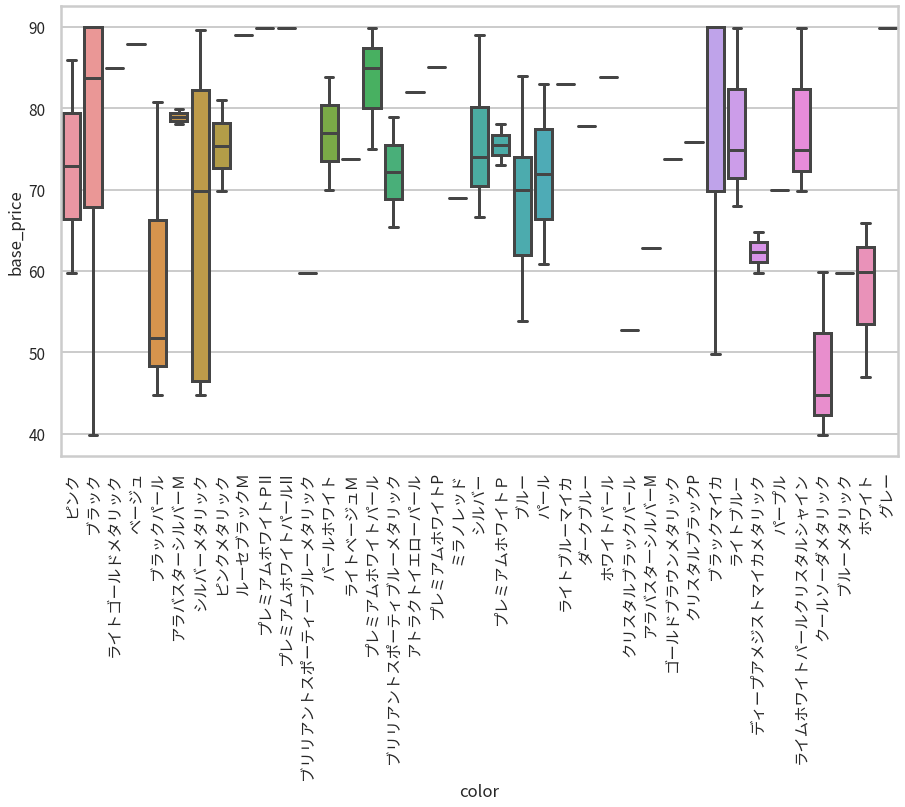

In [109]:
sns.set(rc={'figure.figsize': (15, 8.27)})
sns.set_style("whitegrid", rc={"font.family": "Noto Sans CJK JP"})
sns.set_context("poster", font_scale=0.7)
g = sns.boxplot(x="color", y="base_price", data=cars)
a = g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [124]:
show_columns = ['url','base_price','total_price','model_year','distance','repare','model','color']
for c, df in cars.groupby('color',as_index=False):
    print(c)
    display(df[show_columns])

アトラクトイエローパール


,url,base_price,total_price,model_year,distance,repare,model,color
17,https://www.carsensor.net/usedcar/detail/VU529...,82.0,96.3,2014,4.1,なし,FIT,アトラクトイエローパール


アラバスタ―シルバーM


,url,base_price,total_price,model_year,distance,repare,model,color
35,https://www.carsensor.net/usedcar/detail/VU502...,62.8,78.6,2014,2.8,なし,GRACE,アラバスタ―シルバーM


アラバスターシルバーＭ


,url,base_price,total_price,model_year,distance,repare,model,color
5,https://www.carsensor.net/usedcar/detail/VU552...,79.9,102.9,2013,4.8,なし,FIT,アラバスターシルバーＭ
15,https://www.carsensor.net/usedcar/detail/VU552...,78.0,91.1,2014,7.3,なし,FIT,アラバスターシルバーＭ


クリスタルブラックP


,url,base_price,total_price,model_year,distance,repare,model,color
37,https://www.carsensor.net/usedcar/detail/VU549...,75.8,91.2,2015,9.3,なし,JADE,クリスタルブラックP


クリスタルブラックパール


,url,base_price,total_price,model_year,distance,repare,model,color
32,https://www.carsensor.net/usedcar/detail/VU496...,52.8,68.9,2015,9.6,なし,SHUTTLE,クリスタルブラックパール


クールソーダメタリック


,url,base_price,total_price,model_year,distance,repare,model,color
63,https://www.carsensor.net/usedcar/detail/VU486...,39.8,59.8,2013,6.4,なし,AQUA,クールソーダメタリック
64,https://www.carsensor.net/usedcar/detail/VU558...,44.8,59.8,2013,6.9,なし,AQUA,クールソーダメタリック
65,https://www.carsensor.net/usedcar/detail/VU508...,59.9,77.9,2013,5.2,なし,AQUA,クールソーダメタリック


グレー


,url,base_price,total_price,model_year,distance,repare,model,color
79,https://www.carsensor.net/usedcar/detail/VU549...,89.8,118.69,2017,4.1,なし,NOTE,グレー


ゴールドブラウンメタリック


,url,base_price,total_price,model_year,distance,repare,model,color
36,https://www.carsensor.net/usedcar/detail/VU507...,73.8,89.6,2014,5.8,なし,GRACE,ゴールドブラウンメタリック


シルバー


,url,base_price,total_price,model_year,distance,repare,model,color
21,https://www.carsensor.net/usedcar/detail/VU548...,66.6,82.2,2013,5.2,なし,FIT,シルバー
34,https://www.carsensor.net/usedcar/detail/VU522...,80.1,90.1,2015,8.1,なし,GRACE,シルバー
39,https://www.carsensor.net/usedcar/detail/VU492...,80.1,87.1,2014,6.7,なし,FIELDER,シルバー
41,https://www.carsensor.net/usedcar/detail/VU557...,74.0,83.7,2014,8.1,なし,FIELDER,シルバー
68,https://www.carsensor.net/usedcar/detail/VU535...,72.9,89.9,2016,5.6,なし,AQUA,シルバー
78,https://www.carsensor.net/usedcar/detail/VU444...,68.0,79.0,2015,5.9,なし,AQUA,シルバー
80,https://www.carsensor.net/usedcar/detail/VU491...,89.0,99.6,2017,6.3,なし,NOTE,シルバー


シルバーメタリック


,url,base_price,total_price,model_year,distance,repare,model,color
6,https://www.carsensor.net/usedcar/detail/VU501...,79.9,102.90,2013,1.0,なし,FIT,シルバーメタリック
40,https://www.carsensor.net/usedcar/detail/VU560...,84.5,98.60,2016,6.4,なし,FIELDER,シルバーメタリック
48,https://www.carsensor.net/usedcar/detail/VU560...,89.6,103.60,2018,8.9,なし,VITZ,シルバーメタリック
52,https://www.carsensor.net/usedcar/detail/VU490...,48.0,63.30,2015,8.0,あり,AQUA,シルバーメタリック
69,https://www.carsensor.net/usedcar/detail/VU507...,69.8,118.69,2016,6.4,なし,AQUA,シルバーメタリック
74,https://www.carsensor.net/usedcar/detail/VU508...,45.0,60.30,2015,8.3,あり,AQUA,シルバーメタリック
75,https://www.carsensor.net/usedcar/detail/VU419...,44.8,60.90,2015,6.7,なし,AQUA,シルバーメタリック


ダークブルー


,url,base_price,total_price,model_year,distance,repare,model,color
30,https://www.carsensor.net/usedcar/detail/VU544...,77.8,92.8,2016,9.5,なし,SHUTTLE,ダークブルー


ディープアメジストマイカメタリック


,url,base_price,total_price,model_year,distance,repare,model,color
49,https://www.carsensor.net/usedcar/detail/VU549...,64.8,77.4,2016,5.3,なし,AQUA,ディープアメジストマイカメタリック
60,https://www.carsensor.net/usedcar/detail/VU533...,59.8,72.4,2014,3.5,なし,AQUA,ディープアメジストマイカメタリック


パープル


,url,base_price,total_price,model_year,distance,repare,model,color
59,https://www.carsensor.net/usedcar/detail/VU537...,69.9,70.0,2014,7.2,あり,AQUA,パープル


パール


,url,base_price,total_price,model_year,distance,repare,model,color
27,https://www.carsensor.net/usedcar/detail/VU553...,60.8,75.8,2014,9.1,なし,FIT,パール
33,https://www.carsensor.net/usedcar/detail/VU515...,82.9,85.0,2015,6.3,あり,GRACE,パール


パールホワイト


,url,base_price,total_price,model_year,distance,repare,model,color
12,https://www.carsensor.net/usedcar/detail/VU552...,70.0,84.00,2014,5.0,なし,FIT,パールホワイト
46,https://www.carsensor.net/usedcar/detail/VU537...,83.8,118.69,2014,7.3,なし,FIELDER,パールホワイト


ピンク


,url,base_price,total_price,model_year,distance,repare,model,color
0,https://www.carsensor.net/usedcar/detail/VU342...,85.9,99.0,2017,6.0,なし,FIT,ピンク
54,https://www.carsensor.net/usedcar/detail/VU451...,59.8,69.8,2015,7.6,なし,AQUA,ピンク


ピンクメタリック


,url,base_price,total_price,model_year,distance,repare,model,color
7,https://www.carsensor.net/usedcar/detail/VU527...,81.0,95.5,2016,7.0,あり,FIT,ピンクメタリック
56,https://www.carsensor.net/usedcar/detail/VU463...,69.8,79.8,2015,6.9,なし,AQUA,ピンクメタリック


ブラック


,url,base_price,total_price,model_year,distance,repare,model,color
1,https://www.carsensor.net/usedcar/detail/VU550...,67.8,82.8,2014,6.4,なし,FIT,ブラック
28,https://www.carsensor.net/usedcar/detail/VU549...,83.7,95.2,2014,2.1,あり,FIT,ブラック
45,https://www.carsensor.net/usedcar/detail/VU562...,90.0,99.7,2014,6.6,なし,FIELDER,ブラック
47,https://www.carsensor.net/usedcar/detail/VU555...,90.0,98.4,2013,6.1,なし,FIELDER,ブラック
62,https://www.carsensor.net/usedcar/detail/VU548...,39.8,54.3,2013,9.9,なし,AQUA,ブラック


ブラックパール


,url,base_price,total_price,model_year,distance,repare,model,color
4,https://www.carsensor.net/usedcar/detail/VU441...,44.8,59.8,2013,7.1,なし,FIT,ブラックパール
53,https://www.carsensor.net/usedcar/detail/VU318...,51.8,66.8,2015,9.8,なし,AQUA,ブラックパール
66,https://www.carsensor.net/usedcar/detail/VU489...,80.8,95.8,2013,7.2,なし,AQUA,ブラックパール


ブラックマイカ


,url,base_price,total_price,model_year,distance,repare,model,color
38,https://www.carsensor.net/usedcar/detail/VU527...,89.9,107.9,2014,6.4,なし,FIELDER,ブラックマイカ
57,https://www.carsensor.net/usedcar/detail/VU446...,49.8,65.5,2014,7.5,なし,AQUA,ブラックマイカ
67,https://www.carsensor.net/usedcar/detail/VU558...,89.9,107.9,2013,2.0,なし,AQUA,ブラックマイカ


ブリリアントスポーティブルーメタリック


,url,base_price,total_price,model_year,distance,repare,model,color
16,https://www.carsensor.net/usedcar/detail/VU560...,78.9,91.9,2014,4.6,なし,FIT,ブリリアントスポーティブルーメタリック
26,https://www.carsensor.net/usedcar/detail/VU528...,65.4,72.0,2014,7.4,なし,FIT,ブリリアントスポーティブルーメタリック


ブリリアントスポーティーブルーメタリック


,url,base_price,total_price,model_year,distance,repare,model,color
11,https://www.carsensor.net/usedcar/detail/VU540...,59.8,73.1,2014,8.3,なし,FIT,ブリリアントスポーティーブルーメタリック


ブルー


,url,base_price,total_price,model_year,distance,repare,model,color
25,https://www.carsensor.net/usedcar/detail/VU560...,53.8,68.8,2014,6.2,なし,FIT,ブルー
42,https://www.carsensor.net/usedcar/detail/VU538...,74.0,84.3,2014,6.5,なし,FIELDER,ブルー
44,https://www.carsensor.net/usedcar/detail/VU525...,62.0,72.3,2014,9.6,あり,FIELDER,ブルー
51,https://www.carsensor.net/usedcar/detail/VU506...,84.0,85.0,2016,5.7,あり,AQUA,ブルー
58,https://www.carsensor.net/usedcar/detail/VU556...,69.9,70.0,2014,9.2,あり,AQUA,ブルー


ブルーメタリック


,url,base_price,total_price,model_year,distance,repare,model,color
70,https://www.carsensor.net/usedcar/detail/VU448...,59.8,75.5,2016,8.6,なし,AQUA,ブルーメタリック


プレミアムホワイトP


,url,base_price,total_price,model_year,distance,repare,model,color
18,https://www.carsensor.net/usedcar/detail/VU560...,85.0,97.7,2014,6.4,なし,FIT,プレミアムホワイトP


プレミアムホワイトパール


,url,base_price,total_price,model_year,distance,repare,model,color
14,https://www.carsensor.net/usedcar/detail/VU525...,75.0,90.3,2014,8.2,なし,FIT,プレミアムホワイトパール
19,https://www.carsensor.net/usedcar/detail/VU549...,89.8,100.2,2014,6.1,なし,FIT,プレミアムホワイトパール
24,https://www.carsensor.net/usedcar/detail/VU538...,84.9,95.9,2014,1.0,なし,FIT,プレミアムホワイトパール


プレミアムホワイトパールII


,url,base_price,total_price,model_year,distance,repare,model,color
10,https://www.carsensor.net/usedcar/detail/VU514...,89.8,104.2,2016,4.2,なし,FIT,プレミアムホワイトパールII


プレミアムホワイトＰ


,url,base_price,total_price,model_year,distance,repare,model,color
22,https://www.carsensor.net/usedcar/detail/VU542...,73.0,85.2,2013,9.2,なし,FIT,プレミアムホワイトＰ
23,https://www.carsensor.net/usedcar/detail/VU547...,78.0,90.9,2013,2.5,なし,FIT,プレミアムホワイトＰ


プレミアムホワイトＰII


,url,base_price,total_price,model_year,distance,repare,model,color
9,https://www.carsensor.net/usedcar/detail/VU529...,89.8,102.0,2016,7.0,なし,FIT,プレミアムホワイトＰII


ベージュ


,url,base_price,total_price,model_year,distance,repare,model,color
3,https://www.carsensor.net/usedcar/detail/VU529...,87.9,88.0,2014,2.6,なし,FIT,ベージュ


ホワイト


,url,base_price,total_price,model_year,distance,repare,model,color
73,https://www.carsensor.net/usedcar/detail/VU332...,59.9,60.0,2015,9.0,あり,AQUA,ホワイト
76,https://www.carsensor.net/usedcar/detail/VU501...,47.0,62.5,2015,8.5,なし,AQUA,ホワイト
77,https://www.carsensor.net/usedcar/detail/VU489...,65.9,66.0,2015,7.4,なし,AQUA,ホワイト


ホワイトパール


,url,base_price,total_price,model_year,distance,repare,model,color
31,https://www.carsensor.net/usedcar/detail/VU547...,83.8,98.8,2015,9.6,なし,SHUTTLE,ホワイトパール


ミラノレッド


,url,base_price,total_price,model_year,distance,repare,model,color
20,https://www.carsensor.net/usedcar/detail/VU458...,69.0,81.3,2013,1.8,なし,FIT,ミラノレッド


ライトゴールドメタリック


,url,base_price,total_price,model_year,distance,repare,model,color
2,https://www.carsensor.net/usedcar/detail/VU553...,84.9,85.0,2014,0.9,なし,FIT,ライトゴールドメタリック


ライトブルー


,url,base_price,total_price,model_year,distance,repare,model,color
43,https://www.carsensor.net/usedcar/detail/VU503...,89.8,107.0,2013,2.3,なし,FIELDER,ライトブルー
50,https://www.carsensor.net/usedcar/detail/VU457...,68.0,85.0,2016,6.3,なし,AQUA,ライトブルー
55,https://www.carsensor.net/usedcar/detail/VU546...,74.9,75.0,2015,6.0,あり,AQUA,ライトブルー


ライトブルーマイカ


,url,base_price,total_price,model_year,distance,repare,model,color
29,https://www.carsensor.net/usedcar/detail/VU352...,83.0,97.0,2014,5.0,なし,FIT,ライトブルーマイカ


ライトベージュＭ


,url,base_price,total_price,model_year,distance,repare,model,color
13,https://www.carsensor.net/usedcar/detail/VU538...,73.8,87.2,2014,5.9,なし,FIT,ライトベージュＭ


ライムホワイトパールクリスタルシャイン


,url,base_price,total_price,model_year,distance,repare,model,color
61,https://www.carsensor.net/usedcar/detail/VU528...,89.8,104.8,2014,9.3,なし,AQUA,ライムホワイトパールクリスタルシャイン
71,https://www.carsensor.net/usedcar/detail/VU471...,69.8,82.4,2016,7.0,なし,AQUA,ライムホワイトパールクリスタルシャイン
72,https://www.carsensor.net/usedcar/detail/VU471...,74.8,87.4,2016,6.1,なし,AQUA,ライムホワイトパールクリスタルシャイン


ルーセブラックＭ


,url,base_price,total_price,model_year,distance,repare,model,color
8,https://www.carsensor.net/usedcar/detail/VU547...,89.0,101.5,2016,6.8,なし,FIT,ルーセブラックＭ


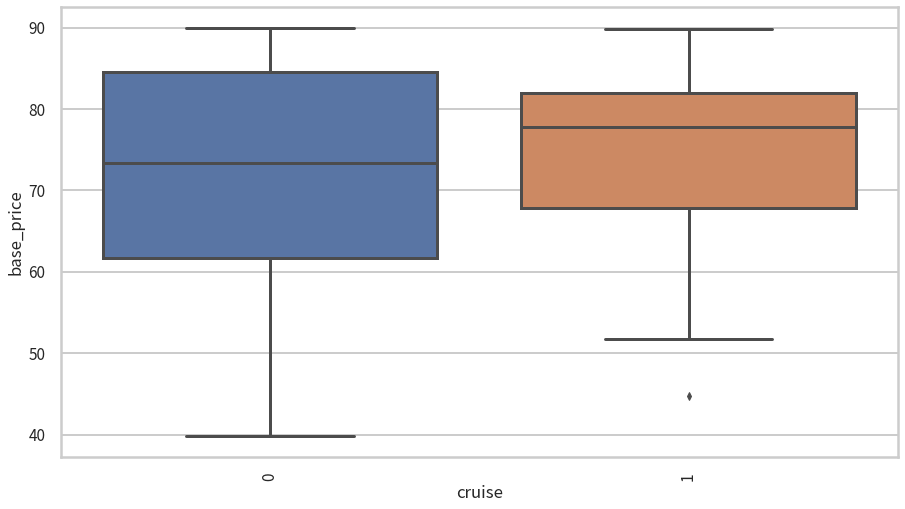

In [125]:
sns.set(rc={'figure.figsize':(15,8.27)})
sns.set_style("whitegrid", rc= {"font.family": "Noto Sans CJK JP"})
sns.set_context("poster", font_scale = 0.7)
g = sns.boxplot(x="cruise", y="base_price", data=cars)
a = g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [126]:
display(cars.loc[cars['cruise']==1,show_columns].sort_values(['base_price']))

,url,base_price,total_price,model_year,distance,repare,model,color
4,https://www.carsensor.net/usedcar/detail/VU441...,44.8,59.8,2013,7.1,なし,FIT,ブラックパール
53,https://www.carsensor.net/usedcar/detail/VU318...,51.8,66.8,2015,9.8,なし,AQUA,ブラックパール
25,https://www.carsensor.net/usedcar/detail/VU560...,53.8,68.8,2014,6.2,なし,FIT,ブルー
70,https://www.carsensor.net/usedcar/detail/VU448...,59.8,75.5,2016,8.6,なし,AQUA,ブルーメタリック
35,https://www.carsensor.net/usedcar/detail/VU502...,62.8,78.6,2014,2.8,なし,GRACE,アラバスタ―シルバーM
1,https://www.carsensor.net/usedcar/detail/VU550...,67.8,82.8,2014,6.4,なし,FIT,ブラック
22,https://www.carsensor.net/usedcar/detail/VU542...,73.0,85.2,2013,9.2,なし,FIT,プレミアムホワイトＰ
36,https://www.carsensor.net/usedcar/detail/VU507...,73.8,89.6,2014,5.8,なし,GRACE,ゴールドブラウンメタリック
14,https://www.carsensor.net/usedcar/detail/VU525...,75.0,90.3,2014,8.2,なし,FIT,プレミアムホワイトパール
37,https://www.carsensor.net/usedcar/detail/VU549...,75.8,91.2,2015,9.3,なし,JADE,クリスタルブラックP
